# Active Learning
Active learning is an iterative process where a model actively selects the most informative data points to be labeled by an oracle (e.g., a human expert), optimizing the model's performance with fewer labeled samples. Active learning can be implemented with Baseprop through Python, as demonstrated by this notebook. This notebook follows Dreiman et al.'s method, using LazyBitVectorPick from RDKit’s MaxMinPicker module to first select 10% of the dataset. Afterward, each step adds an additional 5% of data into the training pool, with the exploitation sample being 0.8X, where X is 5%. The exploration sample makes up the remaining component. As I am not able to obtain the dataset from the original paper, the BACE dataset is used here as a demonstration. The BACE dataset focuses on inhibitors of human beta-secretase 1 (BACE-1) and includes both quantitative (IC50 values) and qualitative (binary labels) binding results.

Dreiman et al.: https://doi.org/10.1177/2472555220949495

NOTE: To simplify the code, I use a notebook to call the APIs in the Baseprop package developed for this task. The functions for hyper-parameter tuning, experiment logging, and tracking are accessible via CLI. CI/CD capabilities are also integrated into this package.

Considerations and design decisions that would be important for this kind of task:
1. **Data Ingestion and Processing**
   Efficiently ingest and process datasets with robust pipelines to ensure high data quality and seamless integration.

2. **Model Training**
   Select suitable models, like graph neural networks, for molecular and biological data. Optimize and validate models for robustness and generalization.

3. **Inference and Candidate Selection**
   Design an efficient inference pipeline to predict properties of unlabelled molecules and prioritize high-potential candidates using parallel processing and hardware acceleration.

4. **Experiment Tracking and Model Management**
   Implement comprehensive tracking and versioning systems for experiments and models. Address model and data drift through regular retraining and performance monitoring.

5. **Iterative Screening and Data Augmentation**
   Establish an iterative screening process with active learning to incorporate new experimental data, enhancing dataset quality and model performance over time.

6. **CI/CD Pipeline**
   Set up a CI/CD pipeline for automated integration, testing, validation, and deployment of updated models, ensuring accuracy and reliability.

7. **Additional Considerations**
   - **Scalability:** Ensure the system can handle large-scale data and workloads.
   - **Security and Compliance:** Maintain data privacy and regulatory compliance.
   - **User Interface:** Develop a user-friendly interface for researchers.
   - **Collaboration:** Integrate with existing research tools to facilitate collaboration.

# Import Packages

In [1]:
import random
from copy import copy
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from lightning import pytorch as pl
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.SimDivFilters import rdSimDivPickers
from torch.utils.data import DataLoader

from baseprop import data, nn
from baseprop.cli.utils.parsing import make_datapoints
from baseprop.models.model import LitModule

# Change data inputs

In [2]:
baseprop_dir = Path.cwd().parent
input_path = baseprop_dir / "tests"/ "data" / "bace.csv" # path to your data .csv file
num_workers = (
    0  # number of workers for dataloader. 0 means using main process for data loading
)
smiles_column = "mol"  # name of the column containing SMILES strings
target_columns = ["Class"]  # list of names of the columns containing targets

## Load data

In [3]:
df_input = pd.read_csv(input_path)
df_input

,mol,Class
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,1
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,1
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,1
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,1
...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,0
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,0
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,0
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,0


In [4]:
df_input.loc[:, target_columns].value_counts()

Class
0        822
1        691
Name: count, dtype: int64

## Get SMILES and targets

In [5]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

In [6]:
smis[:5]  # show first 5 SMILES strings

array(['O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C',
       'Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1',
       'S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(OC)ccc1)Cc1ccccc1)C',
       'S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c(N)c(F)c2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)(C)C)C1',
       'S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C'],
      dtype=object)

In [7]:
ys[:5]  # show first 5 targets

array([[1],
       [1],
       [1],
       [1],
       [1]])

## Get molecule datapoints

In [8]:
smiss = df_input[[smiles_column]].T.values.tolist()
Y = df_input[target_columns]
Y = Y.to_numpy(np.single)
all_data = make_datapoints(
    smiss, Y, molecule_featurizers=["morgan_binary"], keep_h=False, add_h=False
)
# For DNN model, only Morgan fingerprints will be used.
# For the GCNN model, both the molecular graph and the Morgan fingerprint will be used.
# If the Morgan fingerprint is not to be used, you can remove the entry for molecule_featurizers.

## Data splitting for training/validation pool and testing

In [ ]:
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return fingerprint


fingerprints = [smiles_to_fingerprint(s) for s in smis]
num_to_pick = int(len(fingerprints) * 0.1)
picker = rdSimDivPickers.MaxMinPicker()
picked_indices = picker.LazyBitVectorPick(fingerprints, len(fingerprints), num_to_pick)
initial_training_indices = list(picked_indices)
remaining_set_indices = list(set(range(len(smis))) - set(initial_training_indices))
initial_training_data, _, remaining_data = data.split_data_by_indices(
    all_data, [initial_training_indices], None, [remaining_set_indices]
)
initial_training_data = initial_training_data[0]
remaining_data = remaining_data[0]

## Get featurizer

In [10]:
from baseprop.featurizers.atom import get_multi_hot_atom_featurizer
from baseprop.featurizers.bond import MultiHotBondFeaturizer

atom_featurizer = get_multi_hot_atom_featurizer("V1")
bond_featurizer = MultiHotBondFeaturizer()

# Change model inputs here

In [11]:
initial_training_dset = data.MoleculeDataset(
    initial_training_data, atom_featurizer, bond_featurizer
)

In [12]:
# build model
def get_gcnn():
    metric_list = [nn.metrics.BCEMetric(), nn.metrics.BinaryAccuracyMetric()]
    encoder = nn.GCN(n_features=len(initial_training_dset[0].mg.V[0]))
    if initial_training_dset[0].x_d is not None:
        input_dim = encoder.hidden_channels + len(initial_training_dset[0].x_d)
    else:
        input_dim = encoder.hidden_channels
    predictor = nn.BinaryClassificationFFN(input_dim=input_dim)
    model = LitModule(encoder=encoder, predictor=predictor, metrics=metric_list)

    return model


get_gcnn()

LitModule(
  (encoder): GCN(
    (dropout): Dropout(p=0, inplace=False)
    (tau): ReLU()
    (gcn_layers): ModuleList(
      (0): GCNConv(133, 300)
      (1): GCNConv(300, 300)
    )
  )
  (predictor): BinaryClassificationFFN(
    (ffn): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=2348, out_features=300, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): BCELoss()
    (output_transform): Identity()
  )
  (X_d_transform): Identity()
)

In [13]:
# build model
def get_dnn():
    metric_list = [nn.metrics.BCEMetric(), nn.metrics.BinaryAccuracyMetric()]
    input_dim = len(initial_training_dset[0].x_d)
    predictor = nn.BinaryClassificationFFN(input_dim=input_dim)
    model = LitModule(encoder=None, predictor=predictor, metrics=metric_list)

    return model


get_dnn()

LitModule(
  (predictor): BinaryClassificationFFN(
    (ffn): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=2048, out_features=300, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): BCELoss()
    (output_transform): Identity()
  )
  (X_d_transform): Identity()
)

# Change active learning parameters here

In [14]:
query_size = (
    len(all_data) / 20
)  # number of new datapoints added to trainval pool each iteration.

## Getting dataloaders

In [15]:
def get_dataloaders(trainval_indices, test_indices) -> Tuple[DataLoader]:
    shuffle_trainval_indices = copy(trainval_indices)
    random.shuffle(shuffle_trainval_indices)
    split_index = int(len(shuffle_trainval_indices) * 0.9)
    train_indices = shuffle_trainval_indices[:split_index]
    val_indices = shuffle_trainval_indices[split_index:]
    train_data, val_data, test_data = data.split_data_by_indices(
        all_data, [train_indices], [val_indices], [test_indices]
    )

    train_dset = data.MoleculeDataset(train_data[0], atom_featurizer, bond_featurizer)
    val_dset = data.MoleculeDataset(val_data[0], atom_featurizer, bond_featurizer)
    test_dset = data.MoleculeDataset(test_data[0], atom_featurizer, bond_featurizer)

    train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
    val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
    test_loader = data.build_dataloader(
        test_dset, num_workers=num_workers, shuffle=False
    )
    return train_loader, val_loader, test_loader

# Train with active learning

## Set up trainer

In [16]:
def get_trainer():
    return pl.Trainer(
        logger=False,
        enable_checkpointing=True,  # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
        enable_progress_bar=False,
        accelerator="cpu",
        devices=1,
        max_epochs=20,  # number of epochs to train for
    )

## Start training

In [17]:
def active_learning(
    model_func: LitModule,
    trainval_indices: list[int],
    test_indices: list[int],
    n_steps: int = 5,
    priority_function: str = "Dreiman",
):
    true_percentage_list = []
    for i in range(n_steps):
        if i == 0:
            pass
        else:
            # A priority function (or acquistition function) guides the active learning process by selecting the most informative data points to label next.
            # A good choice for such a function is the uncertainty of a model's output on each data point.
            # Here, we follow the paper's (Dreiman et al.) method, acquiring 0.8X for exploitation and 0.2X for exploration.
            if priority_function == "Dreiman":
                sorted_indices_descending = np.argsort(-preds.reshape(-1))
                new_datapoints_indices = sorted_indices_descending[
                    : int(query_size * 0.8)
                ].tolist() + random.choices(
                    sorted_indices_descending[int(query_size * 0.8) :],
                    k=int(query_size * 0.2),
                )
                new_datapoints_indices = [
                    test_indices[i] for i in new_datapoints_indices
                ]  # map back to the original index
                trainval_indices.extend(new_datapoints_indices)
                test_indices = list(set(range(len(all_data))) - set(trainval_indices))
            elif priority_function == "random":
                new_datapoints_indices = random.choices(
                    range(test_indices), k=query_size
                )
                new_datapoints_indices = [
                    test_indices[i] for i in new_datapoints_indices
                ]  # map back to the original index
                trainval_indices.extend(new_datapoints_indices)
                test_indices = list(set(range(len(all_data))) - set(trainval_indices))
        train_loader, val_loader, test_loader = get_dataloaders(
            trainval_indices, test_indices
        )
        trainer = get_trainer()

        model = (
            model_func()
        )  # remove this line to continue training from the previous model
        trainer.fit(model, train_loader, val_loader)

        predss = trainer.predict(
            model, test_loader
        )  # intermediate results can be used for early stopping
        preds = torch.concat(predss, 0)

        true_indices = df_input.index[df_input["Class"] == 1].tolist()
        is_true = [idx in true_indices for idx in trainval_indices]
        true_percentage = (sum(is_true) / len(true_indices)) * 100
        true_percentage_list.append(true_percentage)
    return true_percentage_list

In [18]:
# Active learning for GCNN
trainval_indices = copy(initial_training_indices)
test_indices = list(set(range(len(all_data))) - set(initial_training_indices))

model_func = get_gcnn
y_gcnn = active_learning(
    model_func, n_steps=5, trainval_indices=trainval_indices, test_indices=test_indices
)

/home/scli/miniconda3/envs/baseprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scli/miniconda3/envs/baseprop/lib/python3.11/s ...
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/scli/miniconda3/envs/baseprop/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/scli/miniconda3/envs/baseprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/scli/packages/Baseprop/examples/checkpoints exists and is not empty.

  | Name          | Type                    | Params | Mode 
------------------------------------------------------------------
0 | encoder       | GCN                     | 130 K  | train
1 | predictor     | BinaryClassificationFFN | 705 K  | train
2 | X_d_transform | Identity                | 0      | train
------------------------------------------------------------------
835 K     Trainable params
0         Non-trainable params
835 K     Total params
3.342     Total estimated model params size (MB)
/home/scli/miniconda3/envs/baseprop/lib/python3.11/site-packages/lightning/pytorch/trainer

In [19]:
# Active learning for DNN
trainval_indices = copy(initial_training_indices)
test_indices = list(set(range(len(all_data))) - set(initial_training_indices))

model_func = get_dnn
y_dnn = active_learning(
    model_func, n_steps=5, trainval_indices=trainval_indices, test_indices=test_indices
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                    | Params | Mode 
------------------------------------------------------------------
0 | predictor     | BinaryClassificationFFN | 615 K  | train
1 | X_d_transform | Identity                | 0      | train
------------------------------------------------------------------
615 K     Trainable params
0         Non-trainable params
615 K     Total params
2.460     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                    | Params | Mode 
------------------------------------------------------------------
0 | predictor     | BinaryClassificationFFN | 615 K  | train
1 |

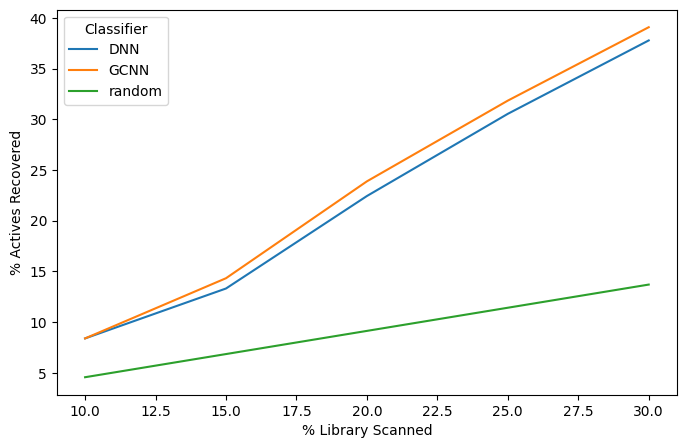

In [20]:
# Plot figure
x = [10, 15, 20, 25, 30]
true_rate = df_input.loc[:, target_columns].value_counts()[1] / len(df_input)
y_random = [i * true_rate for i in x]

plt.figure(figsize=(8, 5))

plt.plot(x, y_dnn, label="DNN")
plt.plot(x, y_gcnn, label="GCNN")
plt.plot(x, y_random, label="random")

plt.legend(loc="upper left", title="Classifier")

plt.xlabel("% Library Scanned")
plt.ylabel("% Actives Recovered")

plt.show()